# Testing SAM Model

In [3]:
#import cv2
import os
import matplotlib.pyplot as plt
import platform
path = r'/Users/mattracz/Downloads/chillcat 2.jpeg' 

assert path is not None, "No file selected"

image = plt.imread(path)

#plt.imshow(image)

#if file doesnt exist error, say "file not found" else imshow

[]

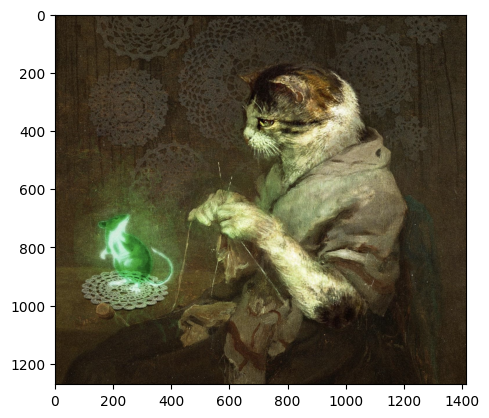

In [6]:
plt.figure() #figsize=(20, 20)
plt.imshow(image)
plt.plot()